<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico 1 : Propiedades en Venta
## Grupo 13
### Integrantes:
- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez 
- Lautaro Barrionuevo
- Nicolás Carreño

# Importe de librerias

In [554]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt


# Lectura de archivo

In [555]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

In [556]:
ds_propiedades.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


# Análisis Exploratorio y Preprocesamiento de Dato

***Filtrado inicial***

Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [557]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)]  #Preguntar si el na va en true

***Exploración inicial***

Tipo de variable

In [558]:
ds_prop_filtrado.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Variables Cuantitativas

In [559]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_prop_filtrado.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

,media,mediana,q1,q3,moda
latitud,-34.591481,-34.59579,-34.615975,-34.577413,-34.541250
longitud,-58.449795,-58.43900,-58.466522,-58.408862,-58.472966
property_rooms,2.822799,3.00000,2.000000,4.000000,3.000000
property_bedrooms,2.014629,2.00000,1.000000,3.000000,1.000000
property_surface_total,109.092970,65.00000,45.000000,105.000000,50.000000
property_surface_covered,87.931932,58.00000,40.000000,88.000000,40.000000
property_price,226238.207185,143900.00000,95000.000000,237000.000000,110000.000000


Variables Cualitativas

In [560]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_prop_filtrado.loc[:,cualitativos]

* Mostrar cantidad de valores posibles

In [561]:
ds_cualitativo.nunique()

place_l2                 1
place_l3                57
operation                1
property_type            3
property_currency        1
property_title       55704
dtype: int64

* Mostrar frecuencias
    * Obviamos las opciones de un solo tipo porque la frecuencia es de 100%

In [562]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

Palermo                 15.248529
Belgrano                 9.482906
Caballito                7.639185
Recoleta                 6.694944
Villa Urquiza            4.980177
Almagro                  4.349263
Nuñez                    3.779095
Villa Crespo             3.398627
Flores                   3.314434
Barrio Norte             3.170560
Balvanera                2.720820
Colegiales               2.079248
Villa Devoto             2.047276
Villa del Parque         1.949228
Saavedra                 1.949228
Puerto Madero            1.591142
San Telmo                1.470714
San Cristobal            1.385455
San Nicolás              1.380126
Retiro                   1.332168
Barracas                 1.327905
Boedo                    1.318314
Floresta                 1.273553
Monserrat                1.188294
Parque Chacabuco         1.143533
Villa Pueyrredón         1.077458
Coghlan                  1.048683
Villa Luro               0.774789
Mataderos                0.766263
Chacarita     

In [563]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

Departamento    85.761122
PH               9.831404
Casa             4.407474
Name: property_type, dtype: float64

In [564]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

Departamento - Palermo                                                                                  1.557576
Departamento - Recoleta                                                                                 1.404789
Departamento - Belgrano                                                                                 1.180914
Departamento - Caballito                                                                                0.993114
Departamento - Almagro                                                                                  0.706639
                                                                                                          ...   
Gran 3 ambientes en pleno Villa del Parque                                                              0.001061
Venta PH 3 Amb Con Patio Flores                                                                         0.001061
Venta, PH, 3 Ambientes, PB, Quincho, Parrilla, Terraza, Paternal                                

* Determinar variables irrelevantes en el análisis

Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. Tambien la caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. Por ultimo, los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas. 

In [565]:
columnas_a_eliminar = ["id","place_l5","place_l6"] # variables irrelevantes, podrian ser: property_title place_l5	place_l6 y (start_date created_on) son lo mismo
ds_filtado_copia = ds_prop_filtrado.copy()
ds_filtado_copia.drop(columns = columnas_a_eliminar, inplace = True)

* Realizar un análisis gráfico de las distribuciones de las variables

In [566]:

#sns.pairplot(ds_filtado_copia)

###Correlaciones existentes entre las variables




*   Analizar las correlaciones existentes entre las variables.



In [567]:
ds_prop_filtrado.corr()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.239235,NaN,0.005521,0.003162,0.025348,0.002352,0.016635
longitud,-0.239235,1.000000,NaN,-0.008324,-0.008556,-0.015056,-0.001155,0.023314
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.005521,-0.008324,NaN,1.000000,0.871940,0.067211,0.076097,0.488934
property_bedrooms,0.003162,-0.008556,NaN,0.871940,1.000000,0.067702,0.075075,0.425386
property_surface_total,0.025348,-0.015056,NaN,0.067211,0.067702,1.000000,0.604311,0.085235
property_surface_covered,0.002352,-0.001155,NaN,0.076097,0.075075,0.604311,1.000000,0.056238
property_price,0.016635,0.023314,NaN,0.488934,0.425386,0.085235,0.056238,1.000000


Precio promedio de propiedad por Barrio

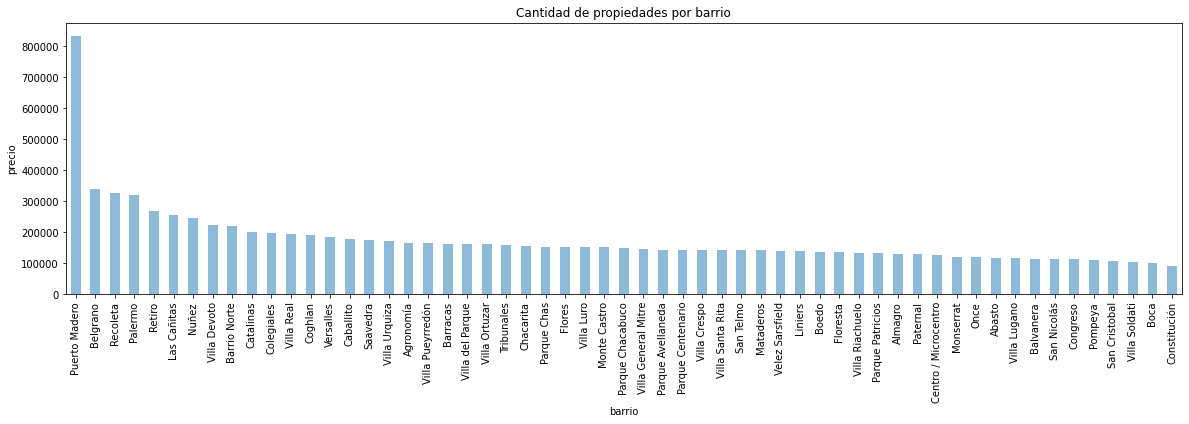

In [568]:
ds_precio_prom = ds_prop_filtrado.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Cantidad de propiedades por barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

# DATOS FALTANTES

Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset

In [569]:
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


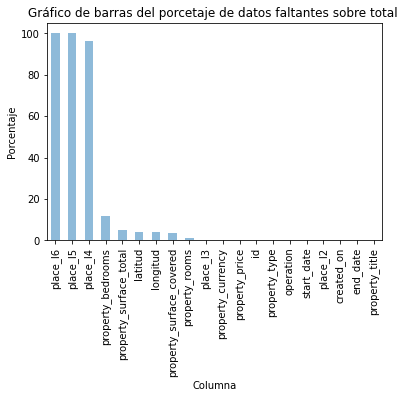

In [570]:
ds_porcentaje = ds_prop_filtrado.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

Nos fijamos si hay algun valor sospechoso que sea negativo

In [571]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(ds_prop_filtrado[columnas_con_numeros] <= 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
property_price,False
property_surface_total,False
property_surface_covered,False
property_rooms,False
property_bedrooms,True


Property_bedrooms tiene numero negativo, asi que veo cuantos hay

In [572]:
ds_prop_filtrado[ds_prop_filtrado['property_bedrooms'] < 1]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Solo hay uno asi que se lo coloca en nan porque no condiciona el analisis pero si el dato es incorrecto

In [573]:
ds_prop_filtrado.loc[ds_prop_filtrado['property_bedrooms'] < 1,'property_bedrooms'] = np.nan
ds_prop_filtrado[ds_prop_filtrado['id'] == '3WI+zCCMeb9TR5kOBm7rhg==']

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Verificamos que no haya duplicados

In [574]:
ds_prop_filtrado[ds_prop_filtrado.duplicated(keep=False)]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title


Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total. En el caso de l5 y l6 son de 100 por ciento por lo cual no se podria completar y en el caso de l4 son las subdivisiones barriales de los cuales muchos no poseen.

In [575]:
columnas_a_eliminar = ["place_l4","place_l5","place_l6","id"]
ds_prop_filtrado.drop(columns = columnas_a_eliminar, inplace = True)

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.

In [576]:
filas_cantidad_nan = pd.DataFrame(ds_prop_filtrado).isna().sum(axis=1).to_frame("cantidad")
cantidad = len(filas_cantidad_nan[filas_cantidad_nan["cantidad"] > 0])
print(f"Hay {cantidad} lineas que poseen uno o mas valores faltantes")

Hay 21387 lineas que poseen uno o mas valores faltantes


*Determinar, de ser posible, estrategias para reparar los valores faltantes.*

Primero procedemos imputando los cualitativos, que en este caso solo es el place_l3.
Utilizando un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.
https://data.buenosaires.gob.ar/dataset/barrios

In [580]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT

for index, registro_prop in ds_prop_filtrado.iterrows():
    if  type(registro_prop["place_l3"]) is str:
        continue
    for index_, registro_barrio in ds_barrios.iterrows():
        if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
            barrio_aux = registro_barrio['BARRIO']
            ds_prop_filtrado['place_l3'][index] = barrio_aux

Luego imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.

In [577]:
#creo que es distinto
ds_prop_filtrado = ds_prop_filtrado[~ds_prop_filtrado["latitud"].isna() & ~ds_prop_filtrado["place_l3"].isna()]

In [578]:
copia_pre_imputacion= ds_prop_filtrado.copy()
mice = ds_prop_filtrado.copy()
#mice= mice[~mice["latitud"].isna() & ~mice["place_l3"].isna()]
columnas=['property_surface_total','property_surface_covered','property_rooms','property_price','property_bedrooms','latitud','longitud'] #,'property_surface_covered','property_bathrooms','property_rooms'
df_eliminar_nans_op3=ds_prop_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean") #imputation_order='roman'
df_eliminar_nans_op3_completo=imp.fit_transform(df_eliminar_nans_op3)
mice['property_surface_total']= df_eliminar_nans_op3_completo[:,0]
mice['property_surface_covered']=df_eliminar_nans_op3_completo[:, 1]
mice['property_rooms']= df_eliminar_nans_op3_completo[:, 2]
mice['property_price']= df_eliminar_nans_op3_completo[:, 3]
mice['property_bedrooms'] = df_eliminar_nans_op3_completo[:,4]
#mice['latitud'] = df_eliminar_nans_op3_completo[:,5]
#mice['longitud'] = df_eliminar_nans_op3_completo[:,6]
#mice['latitud'].drop()
#mice['longitud'].drop()
mice=mice.round()


In [579]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
operation                   0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
property_currency           0.0
property_title              0.0
dtype: float64


In [581]:
#Ver que es
# ds_prop_filtrado.where(ds_prop_filtrado.place_l3.isna(), ds_barrios)

#ds_prop_filtrado["place_l3"].fillna(ds_barrios[ds_barrios["WKT"].contains(Point((ds_prop_filtrado.longitud,ds_prop_filtrado.latitud))) == True].barrio)
#ds_prop_filtrado["place_l3"].isna().combine_first()

In [582]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
operation                   0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
property_currency           0.0
property_title              0.0
dtype: float64


Luego logramos reducir el porcentaje de datos faltantes a 0.21
Investigando, descubrimos que los registros que aun tienen dato faltante, es porque la latitud y longitud no coinciden con un punto ubicado en CABA.

En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

In [583]:
mice[mice["property_price"]<0]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title


***Comparamos property price sin y con imputacion***

<AxesSubplot:ylabel='property_price'>

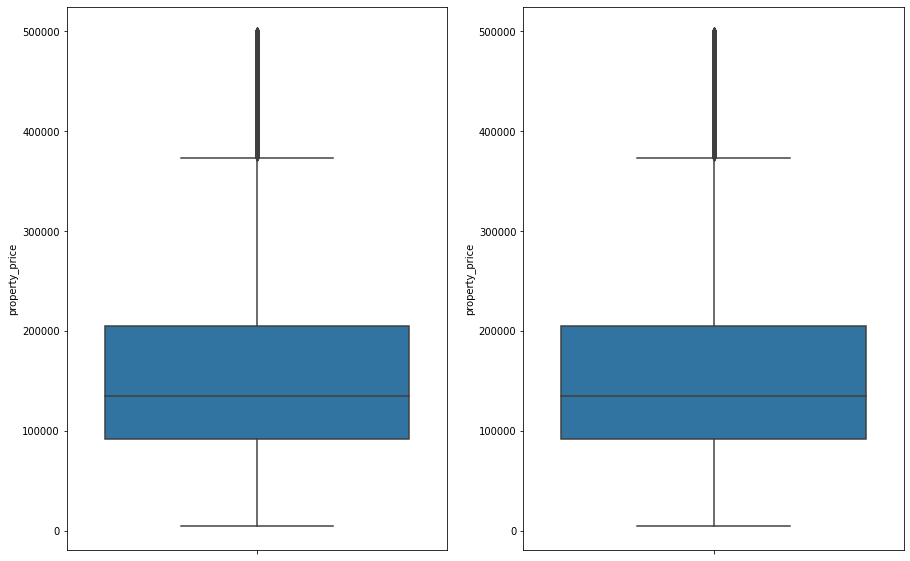

In [584]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_price", data=copia_pre_imputacion[copia_pre_imputacion["property_price"]<500000], ax=axes[0])
sns.boxplot(y="property_price", data=mice[mice["property_price"]<500000], ax=axes[1])

***Comparamos property bedrooms***

<AxesSubplot:>

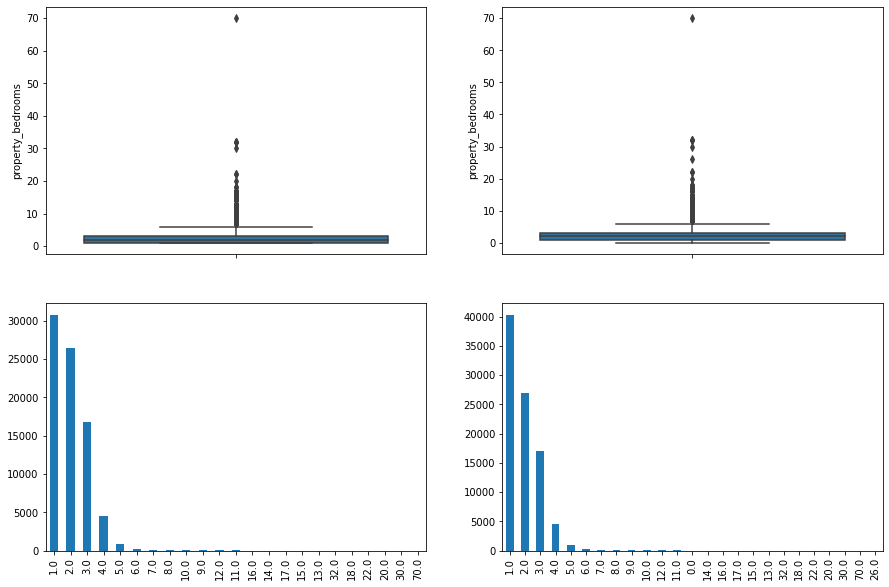

In [585]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_bedrooms", data=copia_pre_imputacion, ax=axes[0,0])
sns.boxplot(y="property_bedrooms", data=mice, ax=axes[0,1])
copia_pre_imputacion["property_bedrooms"].value_counts().plot.bar(ax=axes[1,0])
mice["property_bedrooms"].value_counts().plot.bar(ax=axes[1,1])

El grafico nos muestra que la mayoria de los valores faltantes se complentan co una sola habitacion

# analizar la existencia de valores atípicos


In [586]:
#Calulo el vector de medias
# """
# mice= mice[:300]
# vmedias=np.mean(mice[['property_price','property_rooms']])

# #Calculo la diferencia entre las observaciones y el vector de medias
# x_dif = mice[['property_price','property_rooms']] - vmedias

# #Calculo matriz de covarianza y su inversa
# cov=mice[['property_price','property_rooms']].cov().values
# inv_cov = np.linalg.inv(cov)

# #Calculamos el cuadrado de la distancia de mahalanobis
# mahal =np.dot( np.dot(x_dif, inv_cov) , x_dif.T)

# mice['mahalanobis']=mahal.diagonal()
# mice.head
# """

### Detectar valores atípicos en los datos en forma univariada

In [587]:
ds_atipicos = mice.copy()
columnas_a_eliminar = ["start_date", "end_date", "created_on", "latitud", "longitud", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_atipicos.drop(columns = columnas_a_eliminar, inplace=True)

property_rooms

In [588]:
#z-score Rooms con librería stats
ds_atipicos['z_rooms']=st.zscore(ds_atipicos.property_rooms) #Agregamos columna con valores de z-score

#z-score modificado Rooms con librería stats
mediana_rooms = np.median(ds_atipicos.property_rooms)
MAD=np.median(np.absolute(ds_atipicos.property_rooms - mediana_rooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_rooms']=(ds_atipicos.property_rooms - mediana_rooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro"

In [589]:
ds_atipicos[ds_atipicos['z_rooms'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms
58,10.0,10.0,394.0,244.0,500000.0,5.022178,4.7215
834,9.0,4.0,390.0,340.0,1200000.0,4.321832,4.0470
1040,8.0,6.0,201.0,201.0,345000.0,3.621486,3.3725
1108,8.0,6.0,201.0,201.0,345000.0,3.621486,3.3725
1140,16.0,11.0,10500.0,10500.0,9900000.0,9.224254,8.7685
...,...,...,...,...,...,...,...
459306,8.0,4.0,225.0,225.0,740000.0,3.621486,3.3725
459724,8.0,3.0,285.0,272.0,1250000.0,3.621486,3.3725
459755,8.0,5.0,431.0,415.0,2800000.0,3.621486,3.3725
459764,8.0,4.0,383.0,383.0,1700000.0,3.621486,3.3725


In [590]:
ds_atipicos[ds_atipicos['z_rooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms


<AxesSubplot:ylabel='property_rooms'>

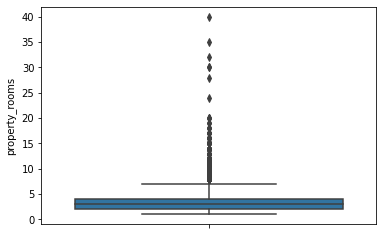

In [591]:
sns.boxplot(y=ds_atipicos.property_rooms)

property_bedrooms

In [592]:
#z-score
ds_atipicos['z_bedrooms']=st.zscore(ds_atipicos.property_bedrooms)

#z-score modificado
mediana_bedrooms = np.median(ds_atipicos.property_bedrooms)
MAD=np.median(np.absolute(ds_atipicos.property_bedrooms - mediana_bedrooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_bedrooms']=(ds_atipicos.property_bedrooms - mediana_bedrooms)*0.6745/MAD

In [593]:
ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
58,10.0,10.0,394.0,244.0,500000.0,5.022178,4.7215,7.274532,5.3960
1040,8.0,6.0,201.0,201.0,345000.0,3.621486,3.3725,3.678594,2.6980
1108,8.0,6.0,201.0,201.0,345000.0,3.621486,3.3725,3.678594,2.6980
1140,16.0,11.0,10500.0,10500.0,9900000.0,9.224254,8.7685,8.173516,6.0705
1349,8.0,6.0,201.0,201.0,345000.0,3.621486,3.3725,3.678594,2.6980
...,...,...,...,...,...,...,...,...,...
457366,7.0,6.0,280.0,230.0,426000.0,2.921140,2.6980,3.678594,2.6980
457782,10.0,6.0,520.0,500.0,3300000.0,5.022178,4.7215,3.678594,2.6980
458670,5.0,6.0,125.0,100.0,265000.0,1.520447,1.3490,3.678594,2.6980
458873,12.0,12.0,820.0,820.0,550000.0,6.422870,6.0705,9.072501,6.7450


In [594]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


<AxesSubplot:ylabel='property_bedrooms'>

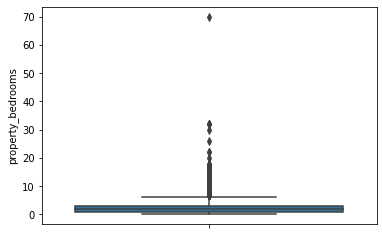

In [595]:
sns.boxplot(y=ds_atipicos.property_bedrooms)

property_surface_total

In [596]:
ds_atipicos['z_surface_total']=st.zscore(ds_atipicos.property_surface_total)
ds_atipicos[ds_atipicos['z_surface_total'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total
1140,16.0,11.0,10500.0,10500.0,9900000.0,9.224254,8.7685,8.173516,6.0705,9.129928
1932,13.0,10.0,186273.0,217000.0,250000.0,7.123216,6.7450,7.274532,5.3960,163.587682
33017,1.0,1.0,4428.0,31.0,58552.0,-1.280937,-1.3490,-0.816328,-0.6745,3.794254
34123,4.0,3.0,5000.0,109.0,418000.0,0.820101,0.6745,0.981641,0.6745,4.296890
35536,1.0,1.0,3660.0,33.0,98000.0,-1.280937,-1.3490,-0.816328,-0.6745,3.119386
72316,2.0,1.0,61130.0,53030.0,225000.0,-0.580591,-0.6745,-0.816328,-0.6745,53.620243
72521,2.0,1.0,33800.0,31670.0,66000.0,-0.580591,-0.6745,-0.816328,-0.6745,29.604436
84073,1.0,1.0,36000.0,30.0,90000.0,-1.280937,-1.3490,-0.816328,-0.6745,31.537651
94789,2.0,1.0,5312.0,4809.0,145000.0,-0.580591,-0.6745,-0.816328,-0.6745,4.571055
104177,1.0,1.0,3623.0,3615.0,110000.0,-1.280937,-1.3490,-0.816328,-0.6745,3.086873


<AxesSubplot:ylabel='property_surface_total'>

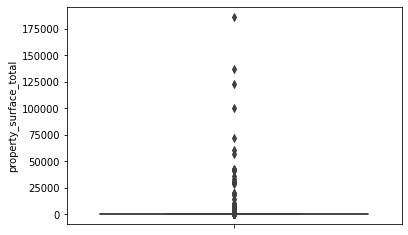

In [597]:
sns.boxplot(y=ds_atipicos.property_surface_total)

property_surface_covered

In [598]:
ds_atipicos['z_surface_covered']=st.zscore(ds_atipicos.property_surface_covered)
ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total,z_surface_covered
1140,16.0,11.0,10500.0,10500.0,9900000.0,9.224254,8.7685,8.173516,6.0705,9.129928,10.473264
1932,13.0,10.0,186273.0,217000.0,250000.0,7.123216,6.7450,7.274532,5.3960,163.587682,218.173842
72316,2.0,1.0,61130.0,53030.0,225000.0,-0.580591,-0.6745,-0.816328,-0.6745,53.620243,53.250531
72521,2.0,1.0,33800.0,31670.0,66000.0,-0.580591,-0.6745,-0.816328,-0.6745,29.604436,31.766345
85725,5.0,4.0,3197.0,3367.0,12000000.0,1.520447,1.3490,1.880625,1.3490,2.712532,3.298793
94789,2.0,1.0,5312.0,4809.0,145000.0,-0.580591,-0.6745,-0.816328,-0.6745,4.571055,4.749177
104177,1.0,1.0,3623.0,3615.0,110000.0,-1.280937,-1.3490,-0.816328,-0.6745,3.086873,3.548235
106598,2.0,1.0,56740.0,52540.0,175000.0,-0.580591,-0.6745,-0.816328,-0.6745,49.762600,52.757682
117835,2.0,1.0,43086.0,40038.0,114000.0,-0.580591,-0.6745,-0.816328,-0.6745,37.764362,40.182996
187888,2.0,1.0,3425.0,3425.0,75000.0,-0.580591,-0.6745,-0.816328,-0.6745,2.912884,3.357131


<AxesSubplot:ylabel='property_surface_covered'>

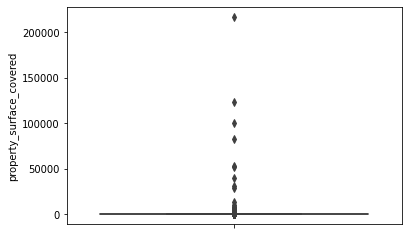

In [599]:
sns.boxplot(y=ds_atipicos.property_surface_covered)

property_price

In [600]:
#z-score
ds_atipicos['z_price']=st.zscore(ds_atipicos.property_price)

#z-score modificado
mediana_price = np.median(ds_atipicos.property_price)
MAD=np.median(np.absolute(ds_atipicos.property_price - mediana_price)) 
ds_atipicos['zm_price']=(ds_atipicos.property_price - mediana_price)*0.6745/MAD

In [601]:
ds_atipicos[ds_atipicos['z_price'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total,z_surface_covered,z_price,zm_price
410,7.0,4.0,400.0,254.0,2700000.0,2.921140,2.6980,1.880625,1.3490,0.254712,0.167695,7.906365,30.269667
411,7.0,4.0,400.0,254.0,2700000.0,2.921140,2.6980,1.880625,1.3490,0.254712,0.167695,7.906365,30.269667
438,4.0,3.0,282.0,256.0,2250000.0,0.820101,0.6745,0.981641,0.6745,0.151022,0.169706,6.469897,24.944667
448,5.0,4.0,304.0,294.0,1200000.0,1.520447,1.3490,1.880625,1.3490,0.170354,0.207927,3.118138,12.519667
629,4.0,3.0,214.0,196.0,1200000.0,0.820101,0.6745,0.981641,0.6745,0.091268,0.109357,3.118138,12.519667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459724,8.0,3.0,285.0,272.0,1250000.0,3.621486,3.3725,0.981641,0.6745,0.153658,0.185799,3.277746,13.111333
459729,6.0,3.0,271.0,265.0,1250000.0,2.220794,2.0235,0.981641,0.6745,0.141356,0.178758,3.277746,13.111333
459755,8.0,5.0,431.0,415.0,2800000.0,3.621486,3.3725,2.779610,2.0235,0.281953,0.329631,8.225580,31.453000
459764,8.0,4.0,383.0,383.0,1700000.0,3.621486,3.3725,1.880625,1.3490,0.239774,0.297445,4.714214,18.436333


<AxesSubplot:ylabel='property_price'>

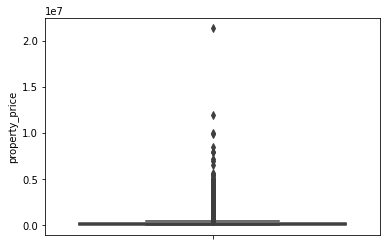

In [602]:
sns.boxplot(y=ds_atipicos.property_price)

### Detectar valores atípicos en los datos en forma multivariada

Analizamos property_price y property_rooms

c:\Users\Axel\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


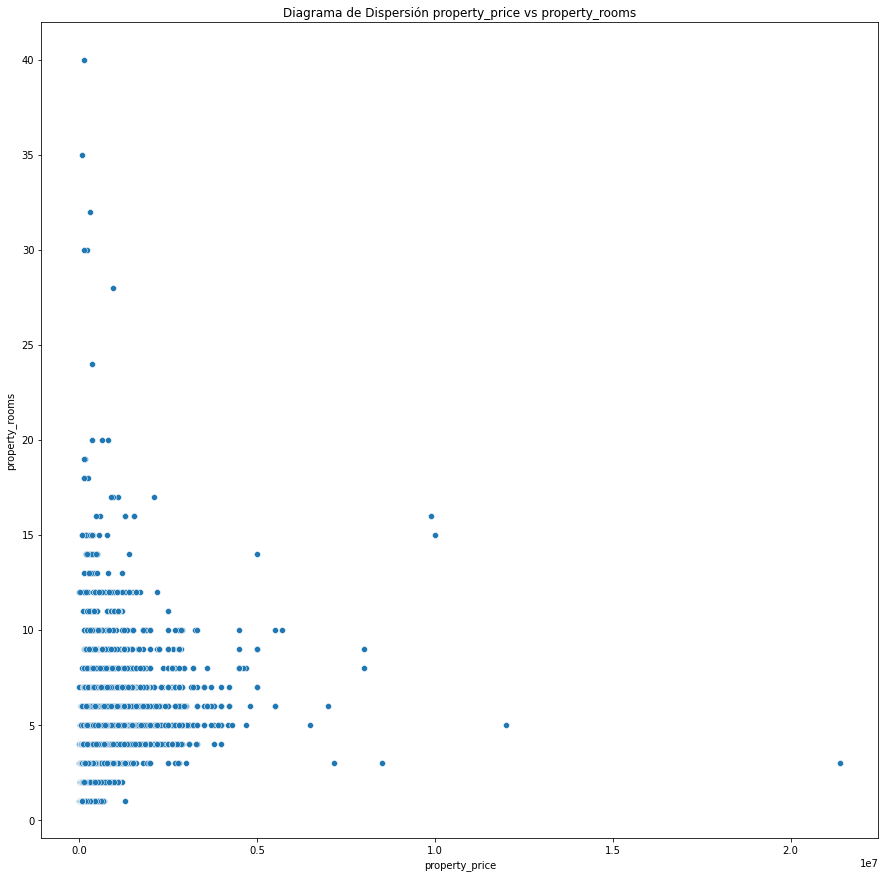

In [603]:
plt.figure(figsize=(15,15))
sns.scatterplot(ds_atipicos['property_price'],ds_atipicos['property_rooms'])
plt.title('Diagrama de Dispersión property_price vs property_rooms')
plt.show()

In [604]:

X=ds_atipicos[['property_price','property_rooms']].values

#Creo el clasificador
clf = LocalOutlierFactor(n_neighbors=20)

#Genero prediccion
y_pred = clf.fit_predict(X)

#Guardo los scores
ds_atipicos['scores_rooms']=clf.negative_outlier_factor_

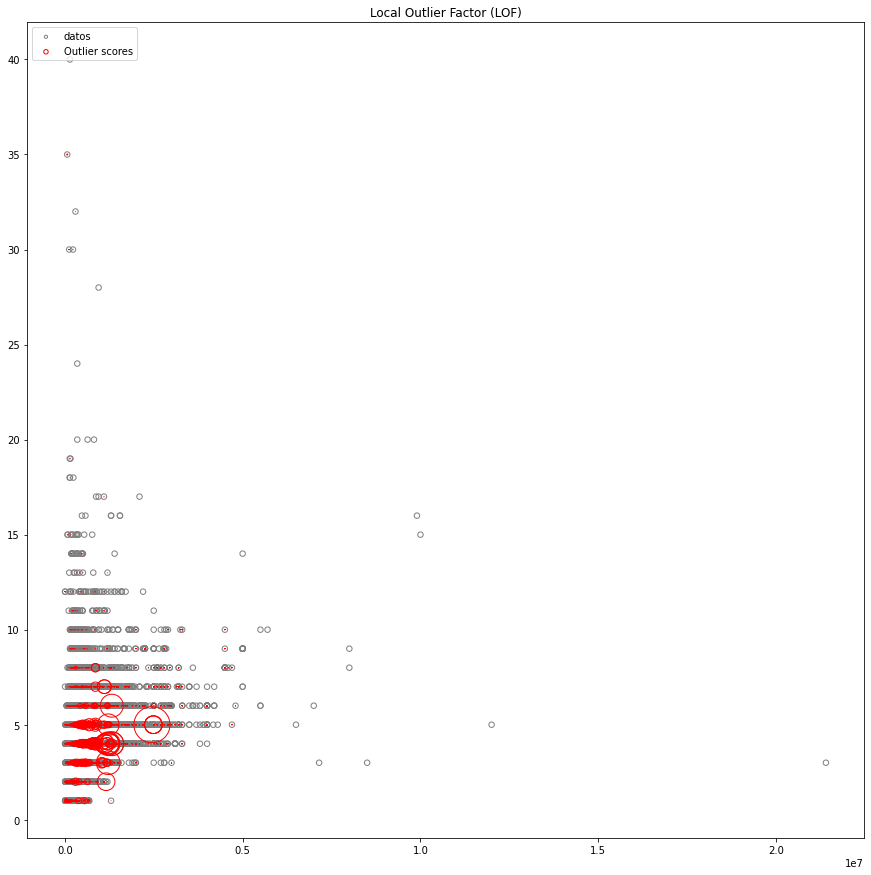

In [605]:
#Calculo radio para plotear score
radius = (ds_atipicos.scores_rooms.max() - ds_atipicos.scores_rooms) / (ds_atipicos.scores_rooms.max() - ds_atipicos.scores_rooms.min())
#Grafico LOF
plt.figure(figsize=(15,15))
plt.title("Local Outlier Factor (LOF)")
plt.scatter(ds_atipicos.property_price.values,ds_atipicos.property_rooms.values, edgecolor='grey', s=30, label='datos',facecolors='none')
plt.scatter(ds_atipicos.property_price.values,ds_atipicos.property_rooms.values, s=1300 * radius, edgecolors='red',facecolors='none', label='Outlier scores')
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
